In [1]:

from pydub import AudioSegment
from tqdm import tqdm
import librosa
import soundfile as sf
import os
import gc
import numpy as np
from matplotlib import pyplot as plt
import warnings
import tensorflow as tf
from pytube import YouTube

In [9]:

#Converting to .wav from .mp3
def mp3_to_wav(audio_path):
    if ".mp3" in audio_path:
        sound = AudioSegment.from_mp3(audio_path)
        sound.export((audio_path[:-3]+"wav"), format="wav")
        os.remove(audio_path)


#Splitting audio into 1 minute length
def split_audio(input_audio, input_file, output_dir, chunk_length=60):
    y, sr = librosa.load(input_file, sr=None)
    num_samples_per_chunk = sr * chunk_length

    num_chunks = len(y) // num_samples_per_chunk + 1

    for i in range(num_chunks):
        start_sample = i * num_samples_per_chunk
        end_sample = min((i + 1) * num_samples_per_chunk, len(y))
        chunk = y[start_sample:end_sample]
        output_file = os.path.join(output_dir, f"chunk_{i}_{input_audio[:-4]}.wav")
        sf.write(output_file, chunk, sr)
        gc.collect()

#Extracting spectrogram images
def extractor(audio_path,output_dir,name):
    y, sr = librosa.load(audio_path)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M_db = librosa.power_to_db(M, ref=np.max)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    del y; del sr; del D; del M;
    gc.collect()

    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

    img1 = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
    ax[0].set(title='STFT (log scale)')

    img2 = librosa.display.specshow(M_db, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set(title='Mel Spectrogram')

    img3 = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', key='Eb:maj', ax=ax[2])
    ax[2].set(title='Chromagram')

    for ax_i in ax:
        ax_i.label_outer()

    fig.set_figwidth(20)
    fig.set_figheight(10)

    plt.subplots_adjust()
    del S_db; del M_db; del chroma;

    fig.savefig(output_dir+f"\{name}.png")
    print("Saved for ",audio_path)
    plt.close()
    gc.collect()


def download_audio(links, output_folder,name):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    link_no = 0
    for link in links:
        try:
            link_no += 1
            yt = YouTube(link)
            audio = yt.streams.filter(only_audio=True).first()
            print(f"Downloading:{yt.title}")
            audio.download(output_folder,filename=f"{name[link_no-1]}.wav")
            print(f"Downloaded audio from {link}")
        except Exception as e:
            print(f"Failed to download {link}: {str(e)}")




In [14]:
#YOUTUBE DOWNLOADS
output_folder = r'E:\Mini_Project\Downloaded'
links = ["https://youtu.be/fvBhW5UtYlM?si=S6wOD5vUPZpROx2C","https://youtu.be/85y7SzjvCjk?si=eAXm452T5lhysMjT","https://youtu.be/99zAJwrBwkQ?si=5vM5IkyQ8P2Fk9yE"]
#download_audio(links,output_folder,["Gujari_Todi_Bhor","Kalyan_Hindol","Pandit_Sorath_Khamaj"])

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#LOCAL FILES
input_file =  r'E:\Mini_Project\Downloaded\Pandit_Sorath_Khamaj.wav'
output_dir = r'E:\Mini_Project\Outputs'

try:
    mp3_to_wav(input_file)
    extractor(input_file,output_dir,"Pandit")
except Exception as e:
    print("Error:",e)
    

Saved for  E:\Mini_Project\Downloaded\Pandit_Sorath_Khamaj.wav


In [4]:
from tensorflow.keras.models import load_model

data_dir = [r'E:\Mini_Project\Review_1_data']
# Loading the Models
model = load_model(r'E:\Mini_Project\Review_1_model\crnn2d_thaatclassifier.h5')

# models = {}
# for i in os.listdir(data_dir[0]):
#     filename = i+".h5"
#     models[i] = load_model("E:/Mini_Project/Review_2_models/"+filename)

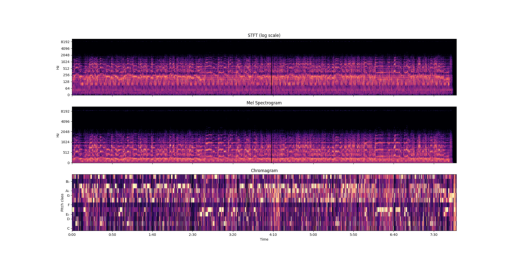


Predicted Thaat: Khamaj
Predicted Raag: Sorath


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np
import warnings
import cv2

warnings.filterwarnings('ignore')

#Class labels
thaat_labels = ['Asavari', 'Bhairav', 'Bhairavi','Bilawal','Kafi','Kalyan','Khamaj', 'Marwa', 'Purvi', 'Todi']

raag_labels = {
    'Asavari': ['Adana', 'Asavari', 'Darbari Kanada', 'Desi', 'Jaunpuri'],
    'Bhairav': ['Ahir Bhairav', 'Bairagi', 'Basant Mukhari', 'Bhairav', 'Bhairav Bahar', 'Bibhas', 'Nat Bhairav'],
    'Bhairavi': ['Bhairavi', 'Bhupal Todi', 'Bilaskhani Todi', 'Komal Ri Asavari', 'Malkauns'],
    'Bilawal': ['Alhaiya Bilawal', 'Bhinna Shadja', 'Bihag', 'Bilaval', 'Durga', 'Hamsadhwani', 'Hemant', 'Pahadi'],
    'Kafi': ['Abhogi', 'Bhageshri', 'Gaud Malhar', 'Jog', 'Madhukauns', 'Miyan Malhar', 'Shudh Saarang'],
    'Kalyan': ['Bhoopali', 'Hindol', 'Kedar', 'Maru Bihag', 'Shudha Kalyan', 'Yaman Kalyan'],
    'Khamaj': ['Desh', 'Jhinjhoti', 'Khamaj', 'Rageshri', 'Sorath'],
    'Marwa': ['Bhatiyar', 'Marwa', 'Purba', 'Puriya', 'Sohni'],
    'Purvi': ['Basant', 'Deepak', 'Gauri', 'Lalit', 'Puriya Dhanashri', 'Purvi', 'Shree'],
    'Todi': ['Gujari Todi', 'Madhuvanti', 'Multani', 'Todi']
}


#Loading and displaying the image
img_path = output_dir+"\Pandit.png"
img_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
#plt.show()

img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0  # Normalize pixel values to range [0, 1]

#Thaat prediction
thaat_predictions = model.predict(x, verbose=0)
thaat_index = np.argmax(thaat_predictions)
predicted_thaat = thaat_labels[thaat_index]

thaat = 'Thaat_'+predicted_thaat
#raag_model = models[thaat]
raag_model = load_model("E:/Mini_Project/Review_2_models/"+thaat+".h5")
raag_predictions = raag_model.predict(x, verbose=0)
raag_index = np.argmax(raag_predictions)
predicted_raag = raag_labels[predicted_thaat][raag_index]

plt.show()
print("\nPredicted Thaat:", predicted_thaat)
print("Predicted Raag:", predicted_raag)